In [1]:
import numpy as np 
import scipy.optimize as sciopt
import matplotlib.pyplot as plt

In [2]:

def plot_four_bar_linkage(dictionary_output):

    def plot_vector(x_s,x_e,col,label=None):
        plt.plot([x_s[0],x_e[0]],[x_s[1],x_e[1]],col,label=label)    
    
    xA = dictionary_output["xA"]
    xB = dictionary_output["xB"]
    yA = dictionary_output["yA"]
    yB = dictionary_output["yB"] 
    xO4 = dictionary_output["xO4"]
    yO4 = dictionary_output["yO4"]     
    
    plt.figure()
    plot_vector([0,0],[xA,yA],'bo-',label="Link 2")
    plot_vector([xA,yA],[xB,yB],'ro-',label="Link 3")
    plot_vector([xB,yB],[xO4,yO4],'ko-',label="Link 4")    
    plt.legend()

def plot_four_bar_linkage_loop(dictionary_output,fignum):

    def plot_vector(x_s,x_e,col,label=None):
        plt.plot([x_s[0],x_e[0]],[x_s[1],x_e[1]],col,label=label)    
    
    xA = dictionary_output["xA"]
    xB = dictionary_output["xB"]
    yA = dictionary_output["yA"]
    yB = dictionary_output["yB"] 
    xO4 = dictionary_output["xO4"]
    yO4 = dictionary_output["yO4"]     
    
    plt.figure(fignum)
    plot_vector([0,0],[xA,yA],'bo-',label="Link 2")
    plot_vector([xA,yA],[xB,yB],'ro-',label="Link 3")
    plot_vector([xB,yB],[xO4,yO4],'ko-',label="Link 4")    
    

def kinematics_four_bar_linkage_problem(theta2,       # We assume we know theta2
                       theta3_guess, # theta3 is unknown. This is the initial guess.
                       theta4_guess, # theta4 is unknown. This is the initial guess.
                       w2,           # We assume we know w2
                       alpha2,       # We assume we know alpha2
                       l1,           # Length of l1
                       l2,           # Length of l2
                       l3,           # Length of l3
                       l4):           # Length of l4

    def position_residual(theta1,theta2,theta3,theta4,l1,l2,l3,l4):     
        eq1 = l2 * np.cos(theta2) + l3 * np.cos(theta3) - l4 * np.cos(theta4) - l1 * np.cos(theta1)
        eq2 = l2 * np.sin(theta2) + l3 * np.sin(theta3) - l4 * np.sin(theta4) - l1 * np.sin(theta1)
        res = np.array([eq1,eq2])
        return res
    
    def solve_function(x):

        return position_residual(0,theta2,x[0],x[1],l1,l2,l3,l4)

    theta3,theta4 = sciopt.fsolve(solve_function,[theta3_guess,theta4_guess])

    xA,yA = np.cos(theta2)*l2 , np.sin(theta2)*l2
    xB,yB = xA + np.cos(theta3)*l3 , yA + np.sin(theta3)*l3
    xO4,yO4 = l1,0
    
    A = np.array([[-l3 * np.cos(theta3),l4*np.cos(theta4)],[-l3 * np.sin(theta3),l4*np.sin(theta4)]]) 
    b = l2 * np.array([np.cos(theta2),np.sin(theta2)]) * w2

    w3,w4 = np.linalg.solve(A,b)
    
    A_acc = np.array([[l3 * np.real(np.exp(1j * theta3) * 1j), -l4 * np.real(np.exp(1j * theta4) * 1j)],
                      [l3 * np.imag(np.exp(1j * theta3) * 1j), -l4 * np.imag(np.exp(1j * theta4) * 1j)]])

    b2 = np.array([np.real(l2 * (-np.exp(1j*theta2) * w2**2 + np.exp(1j*theta2) * 1j * alpha2)),
                   np.imag(l2 * (-np.exp(1j*theta2) * w2**2 + np.exp(1j*theta2) * 1j * alpha2))])

    b3 = np.array([np.real(l3 * (-np.exp(1j*theta3)*w3**2)),
                   np.imag(l3 * (-np.exp(1j*theta3)*w3**2))])

    b4 = np.array([np.real(-l4 * (-np.exp(1j*theta4)*w4**2)),
                   np.imag(-l4 * (-np.exp(1j*theta4)*w4**2))])
    
    b_acc = -b2 - b3 - b4

    alpha3,alpha4 = np.linalg.solve(A_acc,b_acc)
    
    return {"theta2": theta2,
            "theta3": theta3,
            "theta4": theta4,
            "alpha2": alpha2,
            "alpha3": alpha3, 
            "alpha4": alpha4,
            "w2": w2,
            "w3": w3, 
            "w4": w4,            
            "xA": xA,
            "xB": xB,
            "yA": yA,
            "yB": yB,            
            "xO4": xO4,
            "yO4": yO4,
            "l1": l1,
            "l2": l2,
            "l3": l3,
            "l4": l4}

In [3]:

def four_bar_linkage_kinetics(dictionary_kinematics, # Obtained from kinematics analysis                            
                              thetaG2, # Angle between A/O2 and G2/O2 [rad]
                              thetaG3, # Angle between B/A and G3/A [rad]
                              thetaG4, # Angle between B/O4 and G4/O4 [rad]
                              thetaE,
                              l_G2O2,
                              l_G3A,
                              l_EA,
                              l_G4O4,
                              m2, # Length of mass 2 [m]
                              m3, # Length of mass 3 [m]
                              m4, # Length of mass 4 [m]
                              Ig2, # Mass moment of inertia around G2 [kg.m^2]
                              Ig3, # Mass moment of inertia around G3 [kg.m^2]
                              Ig4, # Mass moment of inertia around G4 [kg.m^2]
                              fex, # External force applied to link 3 x-component [N]
                              fey, # External force applied to link 3 y-component [N]
                              T4): # External torque applied to link 4.
     
    theta2 = dictionary_kinematics["theta2"]
    theta3 = dictionary_kinematics["theta3"]
    theta4 = dictionary_kinematics["theta4"]
    
    alpha2 = dictionary_kinematics["alpha2"]
    alpha3 = dictionary_kinematics["alpha3"]
    alpha4 = dictionary_kinematics["alpha4"]

    w2 = dictionary_kinematics["w2"]
    w3 = dictionary_kinematics["w3"]
    w4 = dictionary_kinematics["w4"]
    
    l1 = dictionary_kinematics["l1"]
    l2 = dictionary_kinematics["l2"]
    l3 = dictionary_kinematics["l3"]
    l4 = dictionary_kinematics["l4"]    
    
    xO2 = 0 + 0j
    xA  = l2 * np.exp(1j * theta2)
    xB  = xA + l3 * np.exp(1j * theta3)
    xO4 = l1 + 0j

    xG2 = xO2 + l_G2O2 * np.exp(1j * (theta2 + thetaG2))

    xG3 = xA + l_G3A * np.exp(1j * (theta3 + thetaG3))

    xE  = xA + l_EA * np.exp(1j * (theta3 + thetaE))

    xG4 = xO4 + l_G4O4 * np.exp(1j * (theta4 + thetaG4))
    
    r_O2G2 = xO2 - xG2
    r_AG2  = xA  - xG2
    r_AG3  = xA  - xG3
    r_BG3  = xB  - xG3
    r_BG4  = xB  - xG4
    r_O4G4 = xO4 - xG4
    r_EG3   = xE  - xG3
    
    decompose_real_imag = lambda x: (np.real(x), np.imag(x))
    
    x_O2G,y_O2G = decompose_real_imag(r_O2G2)
    x_AG2,y_AG2 = decompose_real_imag(r_AG2)
    x_AG3,y_AG3 = decompose_real_imag(r_AG3)
    x_BG3,y_BG3 = decompose_real_imag(r_BG3)
    x_BG4,y_BG4 = decompose_real_imag(r_BG4)
    x_O4G4,y_O4G4 = decompose_real_imag(r_O4G4)
    x_EG3,y_EG3 = decompose_real_imag(r_EG3)
    
    alpha_g2 = float(alpha2)
    alpha_g3 = float(alpha3)
    alpha_g4 = float(alpha4)

    def linear_acceleration_of_point_P(aA,lPA,theta,omega,alpha,thetaP):

        aP = aA + lPA * np.exp(1j * (theta + thetaP)) * (-omega**2 + alpha * 1j)

        return aP 

    aG2 = linear_acceleration_of_point_P(0j,l_G2O2,theta2,w2,alpha2,thetaG2)

    aA = linear_acceleration_of_point_P(0j,l2,theta2,w2,alpha2,0)

    aG3 = linear_acceleration_of_point_P(aA,l_G3A,theta3,w3,alpha3,thetaG3)

    aG4 = linear_acceleration_of_point_P(0j,l_G4O4,theta4,w4,alpha4,thetaG4)

    a_G2x,a_G2y = decompose_real_imag(aG2)
    a_G3x,a_G3y = decompose_real_imag(aG3)
    a_G4x,a_G4y = decompose_real_imag(aG4)


    A_row1 = [1,0,1,0,0,0,0,0,0]
    A_row2 = [0,1,0,1,0,0,0,0,0]
    A_row3 = [-y_O2G,x_O2G,-y_AG2,x_AG2,0,0,0,0,1]
    A_row4 = [0,0,-1,0,1,0,0,0,0]
    A_row5 = [0,0,0,-1,0,1,0,0,0]
    A_row6 = [0,0,y_AG3,-x_AG3,-y_BG3,x_BG3,0,0,0]
    A_row7 = [0,0,0,0,-1,0,1,0,0]
    A_row8 = [0,0,0,0,0,-1,0,1,0]
    A_row9 = [0,0,0,0,y_BG4,-x_BG4,-y_O4G4,x_O4G4,0]

    A_matrix = np.array([A_row1,A_row2,A_row3,A_row4,A_row5,A_row6,A_row7,A_row8,A_row9])

    b_vector = np.array([
                         m2 * a_G2x,
                         m2 * a_G2y,
                         Ig2 * alpha_g2,
                         m3 * a_G3x - fex,
                         m3 * a_G3y - fey, 
                         Ig3 * alpha_g3 - (x_EG3 * fey - y_EG3 * fex),
                         m4 * a_G4x, 
                         m4 * a_G4y,     
                         Ig4 * alpha_g4 - T4,
                        ])

    x = np.linalg.solve(A_matrix,b_vector)
    

    dict_output = {}
    labels = ["fO2x","fO2y","fA2x","fA2y","fB3x","fB3y","fO4x","fO4y","T2"]
    for i,j in zip(labels,x):
        dict_output[i] = float(j)
        
    dict_output["theta2"] = theta2
    dict_output["theta3"] = theta3
    dict_output["theta4"] = theta4
    dict_output["w2"] = w2
    dict_output["w3"] = w3
    dict_output["w4"] = w4    
    dict_output["T4"] = T4
    dict_output["alpha2"] = theta2
    dict_output["alpha3"] =  theta3
    dict_output["alpha4"] =  theta4    
    
    return dict_output
    

In [4]:
m2 = 2.64
Ig2 = 0.0064559
m3 = 13.201
Ig3 = 0.80699
m4 = 3.853
Ig4 = 0.02007

l1 = 0.85285
l2 = 0.171296
l3 = 0.856479
l4 = 0.25


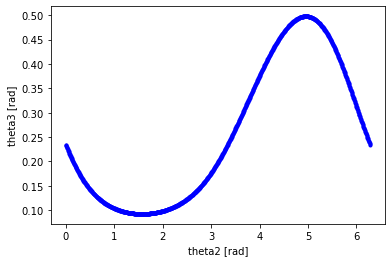

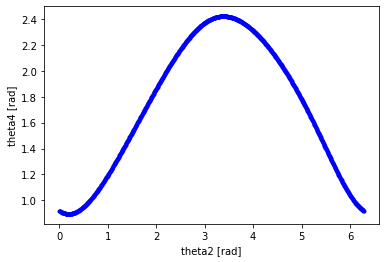

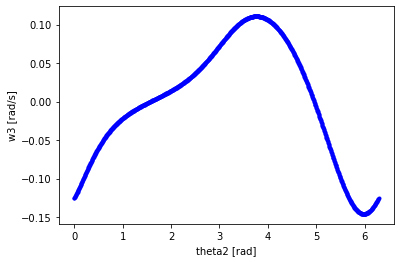

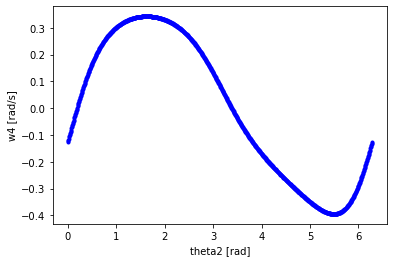

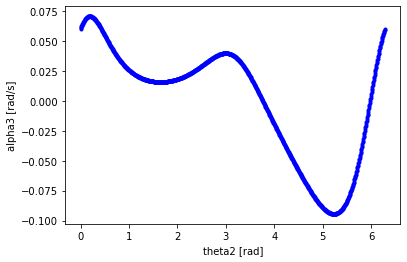

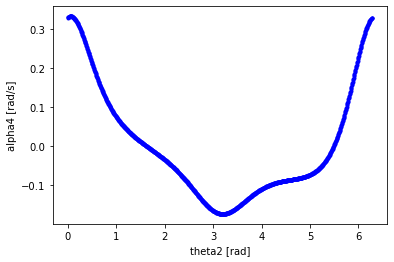

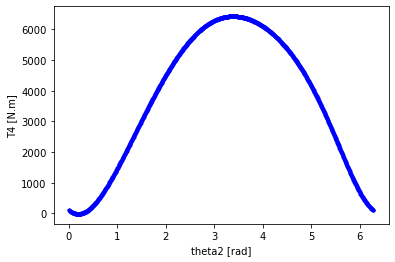

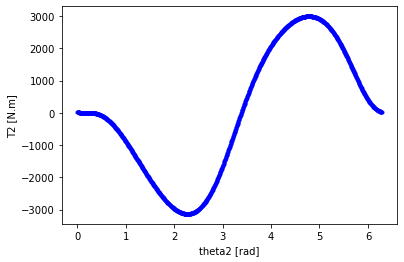

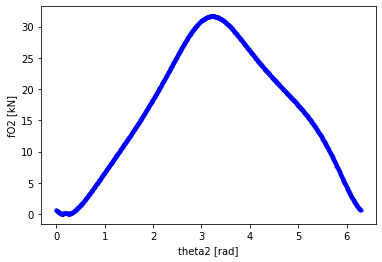

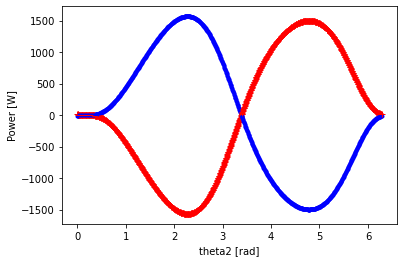

In [5]:
theta2v = np.linspace(0,2*np.pi,1000)

theta3 = np.pi/4
theta4 = np.pi/4

w2 = +0.5
alpha2 =0

theta_vector = []
w_vector = []
alpha_vector = []

for theta2 in theta2v:

    dictkin = kinematics_four_bar_linkage_problem(theta2,       # We assume we know theta2
                           theta3, # theta3 is unknown. This is the initial guess.
                           theta4, # theta4 is unknown. This is the initial guess.
                           w2,           # We assume we know w2
                           alpha2,       # We assume we know alpha2
                           l1,           # Length of l1
                           l2,           # Length of l2
                           l3,           # Length of l3
                           l4)           # Length of l4

    theta3 = dictkin["theta3"]
    theta4 = dictkin["theta4"]
    w3 = dictkin["w3"]
    w4 = dictkin["w4"]
    alpha3 = dictkin["alpha3"]
    alpha4 = dictkin["alpha4"]
    
    thetaG2 = 0
    thetaG3 = 0
    thetaG4 = 0
    thetaE  = 0
    
    l_G2O2 = 0.09105
    l_G3A = 0.42824
    l_G4O4 = l4/2.0
    
    l_EA = 0
    
    T4 = 7700 * np.sin((theta4 * 180/np.pi - 51.526) * np.pi/180 * 90/138.704)
    
    
    dictkinetic = four_bar_linkage_kinetics(dictkin, # Obtained from kinematics analysis                            
                                  thetaG2, # Angle between A/O2 and G2/O2 [rad]
                                  thetaG3, # Angle between B/A and G3/A [rad]
                                  thetaG4, # Angle between B/O4 and G4/O4 [rad]
                                  thetaE,
                                  l_G2O2,
                                  l_G3A,
                                  l_EA,
                                  l_G4O4,
                                  m2, # Length of mass 2 [m]
                                  m3, # Length of mass 3 [m]
                                  m4, # Length of mass 4 [m]
                                  Ig2, # Mass moment of inertia around G2 [kg.m^2]
                                  Ig3, # Mass moment of inertia around G3 [kg.m^2]
                                  Ig4, # Mass moment of inertia around G4 [kg.m^2]
                                  0, # External force applied to link 3 x-component [N]
                                  0, # External force applied to link 3 y-component [N]
                                  T4)    
    
    theta_vector.append([theta2,theta3,theta4])
    w_vector.append([w2,w3,w4])
    

    T4 = dictkinetic["T4"]
    T2 = dictkinetic["T2"]        
    
    plt.figure(1)
    plt.plot(theta2,theta3,'b.')
    plt.ylabel("theta3 [rad]")
    plt.xlabel("theta2 [rad]")
    
    plt.figure(2)
    plt.plot(theta2,theta4,'b.') 
    plt.ylabel("theta4 [rad]")
    plt.xlabel("theta2 [rad]")    
    
    plt.figure(3)
    plt.plot(theta2,w3,'b.')
    plt.ylabel("w3 [rad/s]")
    plt.xlabel("theta2 [rad]")    
    
    plt.figure(4)
    plt.plot(theta2,w4,'b.')     
    plt.ylabel("w4 [rad/s]")
    plt.xlabel("theta2 [rad]")        
    
    plt.figure(5)
    plt.plot(theta2,alpha3,'b.')
    plt.ylabel("alpha3 [rad/s]")
    plt.xlabel("theta2 [rad]")        
    
    
    plt.figure(6)
    plt.plot(theta2,alpha4,'b.')
    plt.ylabel("alpha4 [rad/s]")
    plt.xlabel("theta2 [rad]")      
    
    
    plt.figure(7)
    plt.plot(theta2,T4,'b.')
    plt.ylabel("T4 [N.m]")
    plt.xlabel("theta2 [rad]")      
    
    
    plt.figure(8)
    plt.plot(theta2,T2,'b.')       
    plt.ylabel("T2 [N.m]")
    plt.xlabel("theta2 [rad]")      
    
    
    fO2 = np.abs(dictkinetic["fO2x"] + 1j * dictkinetic["fO2y"])
    
    plt.figure(9)
    plt.plot(theta2,fO2/1000,'b.')  
    plt.ylabel("fO2 [kN]")
    plt.xlabel("theta2 [rad]")     
    
    P4 = T4 * w4
    P2 = T2 * w2
    
    plt.figure(10)
    plt.plot(theta2,P4,'b.')
    plt.plot(theta2,P2,'r+')    
    plt.ylabel("Power [W]")
    plt.xlabel("theta2 [rad]")      
    
    
    

### Mechanical Advantage

$$
\frac{\omega_{in}}{\omega_{out}} \frac{r_{in}}{r_{out}} = \frac{F_{out}}{F_{in}}
$$

### Angular velocity ratio: 

$$
\frac{\omega_{out}}{\omega_{in}}
$$


In [6]:
w_vector = np.array(w_vector)

w2 = w_vector[:,0]
w3 = w_vector[:,1]
w4 = w_vector[:,2]


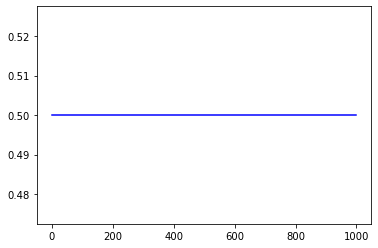

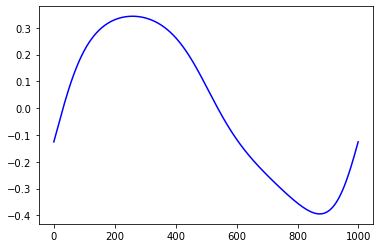

In [7]:
plt.figure(1)
plt.plot(w2,'b')
plt.figure(2)
plt.plot(w4,'b')

In [8]:
mech_adv = w2 * l2 / (w4 * l4)

ang_rat = w4/w2

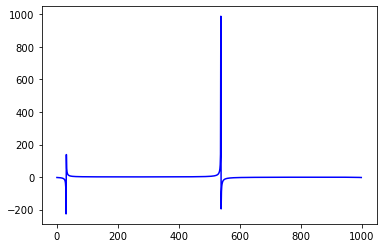

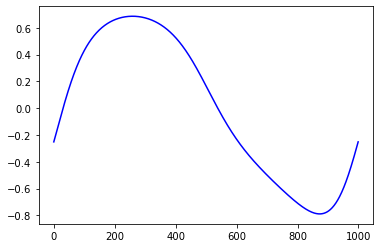

In [9]:
plt.figure(1)
plt.plot(mech_adv,'b')

plt.figure(2)
plt.plot(ang_rat,'b')
